In [ ]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 1119 (delta 17), reused 0 (delta 0), pack-reused 1087
Receiving objects: 100% (1119/1119), 31.32 MiB | 33.55 MiB/s, done.
Resolving deltas: 100% (686/686), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=20898 sha256=bfc61a592d9d0d3f5d1be9abce959b81eb6b12ea213e4de3e89b269bee9852be
  Stored in directory: /tmp/pip-ephem-wheel-cache-oop3qn2q/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [ ]:
!pip install parse

  Created wheel for parse: filename=parse-1.18.0-cp36-none-any.whl size=24134 sha256=7da82a6415f080de24d22bd1ca91c476ae453dee20fb5886579bb09ffc6ab123
  Stored in directory: /root/.cache/pip/wheels/2a/53/09/869ca5781ede342254ffac09ca99461b008c3e5f8dd079b0c0
Successfully built parse


In [ ]:
from deepflows.data_generators import celeba
from deepflows.Utils import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td
from deepflows.Utils.utils import *
from deepflows.data_generators import stochasticMovingMnist
import matplotlib.patches as patches
from deepflows.data_generators.halfmoon import * 
from torchvision.utils import make_grid
device = utils.set_gpu(True)

In [ ]:
rtcs = RotatingTwoMoonsConditionalSampler()

# Load unconditional data
train_set, train_label = rtcs.conditioned_sample(1000, theta=torch.tensor([0]))
test_set, test_label = rtcs.conditioned_sample(2000, theta=torch.tensor([0]))
train_loader, test_loader = loader_half_moons(train_set, test_set, batch_size=64)

In [ ]:
# Get data
x_gu = torch.zeros((10, 1000, 2))
u = torch.zeros((10, 1000, 1))
npi = np.linspace(0, 2, 10)
for i, pi in enumerate(npi):
    rtcs = RotatingTwoMoonsConditionalSampler(noise=0.05)
    x, _ = rtcs.conditioned_sample(1000, theta=torch.tensor([np.pi * pi]))
    u[i] = torch.zeros(1000,1) + i
    x_gu[i] = x

class TwoMoonData(torch.utils.data.Dataset):
    def __init__(self, x, u):
        super(TwoMoonData, self).__init__()
        self.x = x
        self.u = u
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.x[idx], self.u[idx]

dataset = TwoMoonData(x_gu.view(-1,2), u.view(-1,1))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1000,
                        shuffle=True, num_workers=0)

In [ ]:
train_data, test_data = celeba.get_celeba(plot_sample=False)

def get_joint_conditioned_data(data, box_size = (8, 24)):
  i, j = box_size
  x = data.copy()
  y = data.copy()
  h, w=data.shape[-2:]

  # Set the inner square to 0
  x[:, :, i:j, i:j] = 0
  
  # Set the outer square to 0
  get_ids = np.concatenate((np.arange(0, i, 1),np.arange(j, w, 1)))
  y[:, :, get_ids, :] = 0
  y[:, :, :, get_ids] = 0

  return np.concatenate((x, y), axis=1)

trainset = get_joint_conditioned_data(train_data)
testset = get_joint_conditioned_data(test_data)

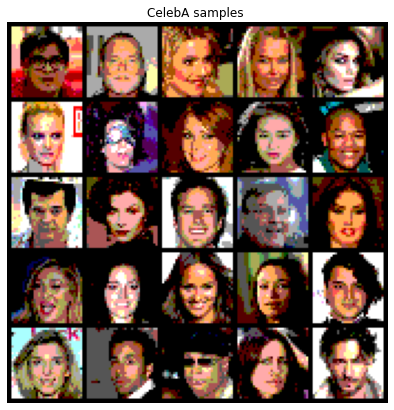

In [ ]:
indices = np.random.choice(len(train_data), replace=False, size=(25,))
samples = (torch.FloatTensor(train_data[indices]) / 3)
grid_img = make_grid(samples, nrow=5)
plt.figure(figsize = (7,7))
plt.title("CelebA samples ")
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.savefig("celeba.pdf", bbox_inches="tight")

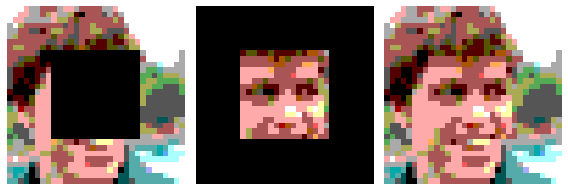

In [ ]:
x, y = torch.tensor(trainset).split(3, 1)
x = x[8].permute(1, 2, 0)
y = y[8].permute(1, 2, 0)
fig, ax = plt.subplots(1, 3, figsize = (8,8))
ax[0].imshow(x/x.max())
ax[1].imshow(y/y.max())
ax[2].imshow((y+x)/(y+x).max())
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
fig.tight_layout()
plt.savefig("celeba_condition.pdf", bbox_inches="tight")

In [ ]:
next(iter(trainset)).shape

(6, 32, 32)

In [ ]:
batch_size = 5
data_set_type = "mnist"

n_frames = 12

testset = stochasticMovingMnist.MovingMNIST(False, 'Mnist', seq_len=n_frames, image_size=64, digit_size=28, num_digits=1, 
                                            deterministic=False, three_channels=False, step_length=4, normalize=False)
trainset = stochasticMovingMnist.MovingMNIST(True, 'Mnist', seq_len=n_frames, image_size=32, digit_size=28, num_digits=1, 
                                              deterministic=False, three_channels=False, step_length=4, normalize=False)
train_loader=DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader=DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last = True)


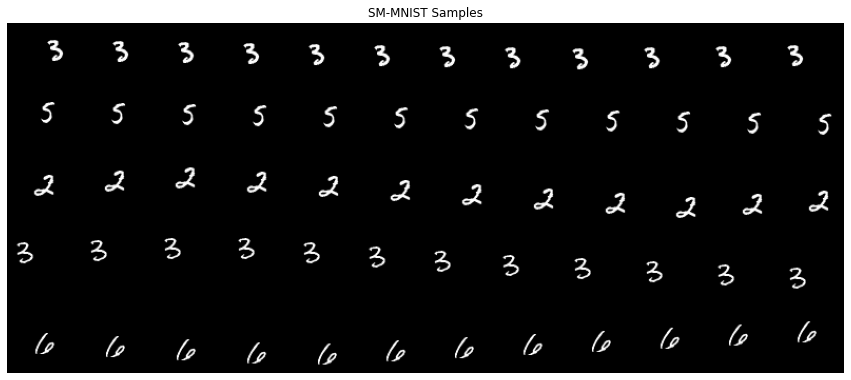

In [ ]:
x_plot = next(iter(test_loader))
grid_img = make_grid(x_plot.view(-1,1,64,64), nrow=n_frames)
plt.figure(figsize = (15,20))
plt.title("SM-MNIST Samples")
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.savefig("sm_mnist.pdf", bbox_inches="tight")

In [ ]:
class SinusWithNoise(object):
    """Data Handler that creates Bouncing MNIST dataset on the fly."""
    def __init__(self, epoch_length=1000, seq_len=20, deterministic=True, step_length=0.1, timeblocks=2, noise_variance=0.1, doublemodulation=False):
        self.seq_len = seq_len
        self.step_length = step_length
        self.deterministic = deterministic
        self.timeblocks = timeblocks
        self.std = noise_variance
        self.N = epoch_length
        self.DM = doublemodulation
          
    def __len__(self):
        return self.N

    def __getitem__(self, index):
        length=self.timeblocks*self.seq_len
        x = np.arange(0,length)*self.step_length
        if self.deterministic==False:
          x= x + np.random.rand(1)*pi*2
        y = np.sin(x)
        if self.deterministic==False:
          y=y+np.random.normal(0, self.std, length)

        return np.reshape(y, [self.timeblocks, self.seq_len])

11


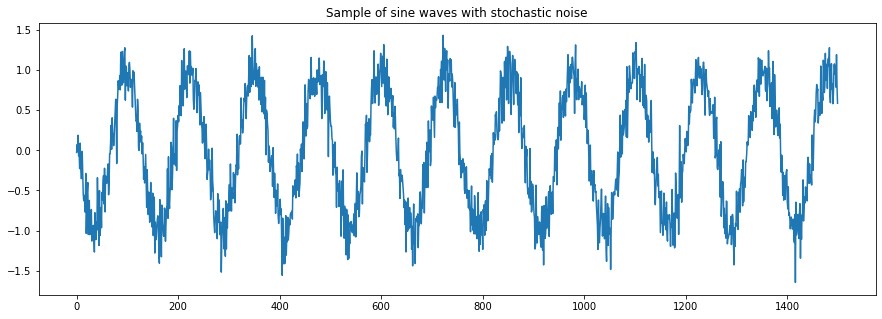

In [ ]:
seq_len = 100
batch_size = 64
noisevar = 0.2
timeblocks = 15
step_len = 0.05
trainset = SinusWithNoise(epoch_length=5000, seq_len=seq_len, deterministic=False, step_length=step_len, timeblocks=timeblocks, noise_variance=noisevar)
train_loader_sinus = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last = True)
testset = SinusWithNoise(epoch_length=100, seq_len=seq_len, deterministic=False, step_length=step_len, timeblocks=timeblocks, noise_variance=noisevar)
test_loader_sinus = DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last = True)

tsteps=3*timeblocks//4
xtest=next(iter(test_loader_sinus)).to(device)
plt.figure(figsize=(15,5))
plt.plot(xtest.view(batch_size,-1)[0].cpu())
plt.title("Sample of sine waves with stochastic noise")
plt.savefig("sinus_data.pdf", bbox_inches="tight")

print(tsteps)

In [ ]:
np.sin(x)

array([0.69109691])

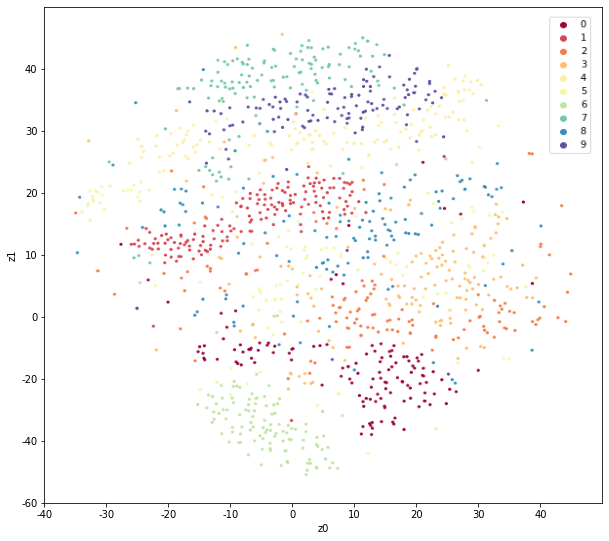

In [ ]:


im='tsne.png'
img=plt.imread(im)
fig, ax = plt.subplots(figsize=(10,10))
x = np.array([-40, -30, -20,-10, 0 , 10, 20, 30, 40])
y = np.array([-60, -40, -20, 0, 10, 20, 30, 40])
ax.imshow(img, extent=[0,len(x),0,len(y)])
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
plt.xlabel("z0")
plt.ylabel("z1")
plt.savefig("tsne.png", bbox_inches="tight")
